In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'ANZ', 'TPG']
weights = np.array([0.25, 0.1, 0.15, 0.1, 0.1, 0.3])

# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix


yf.pdr_override()
stocks = [stock + '.AX' for stock in stockList] #For ASX Stocks
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

#weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)


[*********************100%%**********************]  6 of 6 completed


In [2]:
# Monte Carlo Method
mc_sims = 1000 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 3000

for m in range(0, mc_sims):
    #Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    Z = np.random.standard_t(4,size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio



In [3]:
# 95% VaR and CVaR

def mcVaR(returns, alpha = 5) :
    """Input: pandas series of returns
    Output: percentile on return disribution to a given confidence level alpha  
    """
    if isinstance(returns, pd.Series) :
        return np.percentile(returns, alpha)
    else: 
        raise TypeError("Expected a pandas data series")
        

def mcCVaR(returns, alpha = 5) :
    """Input: pandas series of returns
    Output: CVaR or Expected Shortfall to a given confidence level alpha  
    """
    if isinstance(returns, pd.Series) :
        belowVaR = returns <= mcVaR(returns, alpha = alpha)
        return returns[belowVaR].mean()
    else: 
        raise TypeError("Expected a pandas data series")
        

In [4]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha = 5)

CVaR = initialPortfolio - mcCVaR(portResults, alpha = 5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))


VaR $478.65
CVaR $628.0


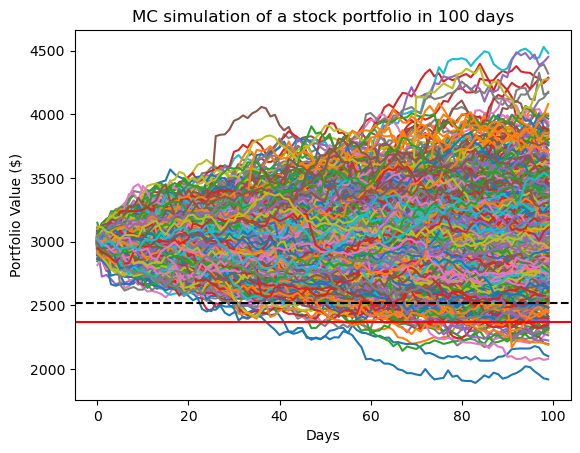

In [5]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.axhline(y = initialPortfolio - VaR, color = 'black', linestyle ="--", label = "VaR")
plt.axhline(y = initialPortfolio - CVaR, color = 'red', linestyle ="-", label = "CVaR")
plt.title('MC simulation of a stock portfolio in 100 days')
plt.show()

In [6]:
#Portfolio Returns Statistics on the 100th day

Avg_portf_returns = np.mean(portfolio_sims)
SD_portf_returns = np.std(portfolio_sims)
Median_portf_returns = np.median(portfolio_sims)

print('Avg_portf_returns ${}'.format(round(Avg_portf_returns,2)))
print('SD_portf_returns ${}'.format(round(SD_portf_returns,2)))
print('Median_portf_returns ${}'.format(round(Median_portf_returns,2)))

#95% confidence Interval of portfolio returns on the 100th day
Avg_CI = np.quantile(portfolio_sims, np.array([0.025, 0.975]))
print(Avg_CI)

Avg_portf_returns $3035.81
SD_portf_returns $265.74
Median_portf_returns $3018.87
[2528.68478758 3624.4733507 ]
